In [3]:
import pickle
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
import os
from cc_hardware.drivers.spads import SPADDataType
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

COUNT = 10 #None if you want to load every capture 
PKL_PATH_INPUT = input("Enter the full path to your .pkl file: ").strip()
PKL_PATH = Path(PKL_PATH_INPUT)

def load_pickles(path, count=None):
    loaded = []
    with open(path, "rb") as f:
        while True:
            try:
                loaded.append(pickle.load(f))
                if count is not None and len(loaded) >= count:
                    break
            except EOFError:
                break
    return loaded
try:
    all_objs = load_pickles(PKL_PATH, count=COUNT)  # Change 'count' to an integer to limit
except FileNotFoundError:
    print(f"ERROR: PKL file not found at '{PKL_PATH}'. Please double-check the path.")
    exit()

if not all_objs:
    print(f"ERROR: PKL file at '{PKL_PATH}' is empty or corrupted.")
    exit()



--- Metadata ---
  object: calibration_3x3_longrange_nopatch_80x45
  spad_position: {'x': 0.1, 'y': 0.4, 'z': 0.5}
  start_time: 2025-09-05T03:42:03.662462
  spad_id: ID6
  range_mode: LONG
  capture_mode: sequential
  repeats_per_point: 1
  robot_grid_points: shape (3600, 3)
  realsense_config: {'color_width': 848, 'color_height': 480, 'depth_width': 848, 'depth_height': 480, 'fps': 30}
  realsense_intrinsics:
    depth: {'ppx': 427.1834716796875, 'ppy': 239.18702697753906, 'fx': 425.82086181640625, 'fy': 425.82086181640625, 'model': 'distortion.brown_conrady', 'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0]}
    color: {'ppx': 424.6217041015625, 'ppy': 242.92385864257812, 'fx': 609.8225708007812, 'fy': 608.9406127929688, 'model': 'distortion.inverse_brown_conrady', 'coeffs': [0.0, 0.0, 0.0, 0.0, 0.0]}
Invalid input. Please enter an integer.
Invalid input. Please enter an integer.

--- Capture Index 3 ---
  Iteration: 3
  Position: None

SPAD RGB: Not Found
SPAD Depth: Not Found
Tracking RGB: No

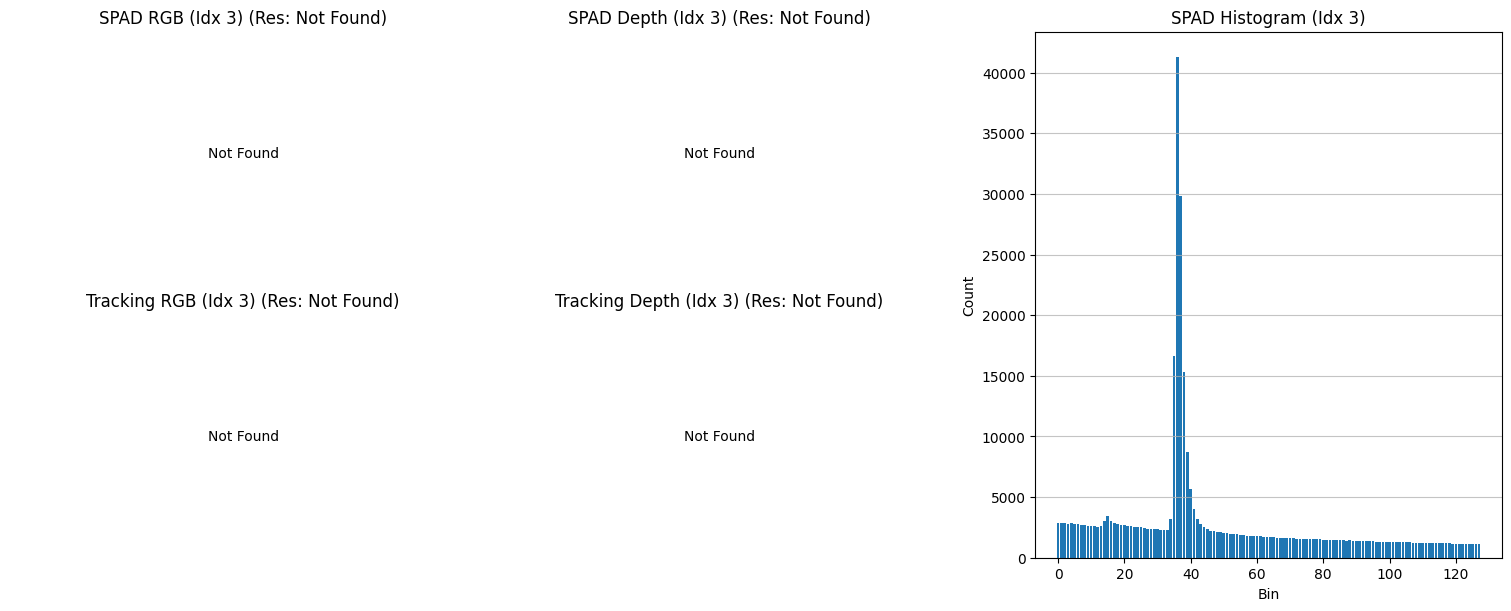

In [4]:
import matplotlib.gridspec as gridspec

metadata_entry, *data_entries = all_objs

# --- Display Metadata ---
print("\n--- Metadata ---")
metadata = metadata_entry.get("metadata", {})
for k, v in metadata.items():
    if isinstance(v, dict) and any(isinstance(sub_v, dict) for sub_v in v.values()):
        print(f"  {k}:")
        for sub_k, sub_v in v.items():
            print(f"    {sub_k}: {sub_v}")
    elif k == "robot_grid_points":
        print(f"  {k}: shape {v.shape}" if hasattr(v, 'shape') else f"  {k}: length {len(v)}")
    else:
        print(f"  {k}: {v}")

# --- Select and Display Capture Data ---
num_captures = len(data_entries)
if num_captures == 0:
    print("\nNo captures found.")
    sys.exit()

while True:
    try:
        idx = int(input(f"\nEnter capture index (0 to {num_captures - 1}): "))
        if 0 <= idx < num_captures: break
        print(f"Invalid index. Range is 0 to {num_captures - 1}.")
    except ValueError:
        print("Invalid input. Please enter an integer.")

capture = data_entries[idx]
print(f"\n--- Capture Index {idx} ---")
print(f"  Iteration: {capture.get('iter')}")
print(f"  Position: {capture.get('pos')}")

# Retrieve data
spad_data = capture.get("spad_realsense_data", {})
tracking_data = capture.get("tracking_realsense_data", {})
hist = capture.get(SPADDataType.HISTOGRAM)

# Print resolutions
def get_res(img):
    return f"{img.shape[1]}x{img.shape[0]}" if img is not None else "Not Found"
print(f"\nSPAD RGB: {get_res(spad_data.get('aligned_rgb_image'))}")
print(f"SPAD Depth: {get_res(spad_data.get('aligned_depth_image'))}")
print(f"Tracking RGB: {get_res(tracking_data.get('aligned_rgb_image'))}")
print(f"Tracking Depth: {get_res(tracking_data.get('aligned_depth_image'))}")

# Plotting
fig = plt.figure(figsize=(15, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[:, 2]) # Histogram spans two rows
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

axes = [ax0, ax1, ax3, ax4]

def plot_img(ax, data, key, title, cmap=None, show_colorbar=False):
    img = data.get(key)
    res = get_res(img)
    if img is None:
        ax.text(0.5, 0.5, "Not Found", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{title} (Res: {res})")
    else:
        im = ax.imshow(img[:, :, ::-1] if img.ndim == 3 else img, cmap=cmap)
        if show_colorbar and cmap:
            fig.colorbar(im, ax=ax, label='Depth (units)')
        ax.set_title(f"{title} (Res: {res})")
    ax.axis('off')

plot_img(axes[0], spad_data, "aligned_rgb_image", f"SPAD RGB (Idx {idx})")
plot_img(axes[1], spad_data, "aligned_depth_image", f"SPAD Depth (Idx {idx})", cmap='jet', show_colorbar=False) # No colorbar
plot_img(axes[2], tracking_data, "aligned_rgb_image", f"Tracking RGB (Idx {idx})")
plot_img(axes[3], tracking_data, "aligned_depth_image", f"Tracking Depth (Idx {idx})", cmap='jet', show_colorbar=False) # No colorbar

# Histogram plot
if hist is not None:
    avg_hist = hist.mean(axis=(0, 1) if hist.ndim == 3 else 0) if isinstance(hist, np.ndarray) and hist.ndim >= 2 else hist
    ax2.bar(range(len(avg_hist)), avg_hist)
    ax2.set_title(f"SPAD Histogram (Idx {idx})")
    ax2.set_xlabel("Bin")
    ax2.set_ylabel("Count")
    ax2.grid(axis='y', alpha=0.75)
else:
    ax2.text(0.5, 0.5, "Histogram Not Found", ha='center', va='center', transform=ax2.transAxes)

plt.show()


--- Metadata ---
  object: calibration_3x3_longrange_nopatch_80x45
  spad_position: {'x': 0.1, 'y': 0.4, 'z': 0.5}
  start_time: 2025-09-05T03:42:03.662462
  spad_id: ID6
  range_mode: LONG
  capture_mode: sequential
  repeats_per_point: 1
  robot_grid_points: shape (3600, 3)
  realsense_config: {'color_width': 848, 'color_height': 480, 'depth_width': 848, 'depth_height': 480, 'fps': 30}
  realsense_intrinsics:
    depth:
      ppx: 427.1834716796875
      ppy: 239.18702697753906
      fx: 425.82086181640625
      fy: 425.82086181640625
      model: distortion.brown_conrady
      coeffs: [0.0, 0.0, 0.0, 0.0, 0.0]
    color:
      ppx: 424.6217041015625
      ppy: 242.92385864257812
      fx: 609.8225708007812
      fy: 608.9406127929688
      model: distortion.inverse_brown_conrady
      coeffs: [0.0, 0.0, 0.0, 0.0, 0.0]

Total captures available: 9

--- Displaying Capture Index 3 ---
  Iteration: 3
  Position: None
Aligned RGB: 848x480 (channels: 3)
Aligned Depth: 848x480 (grayscale/

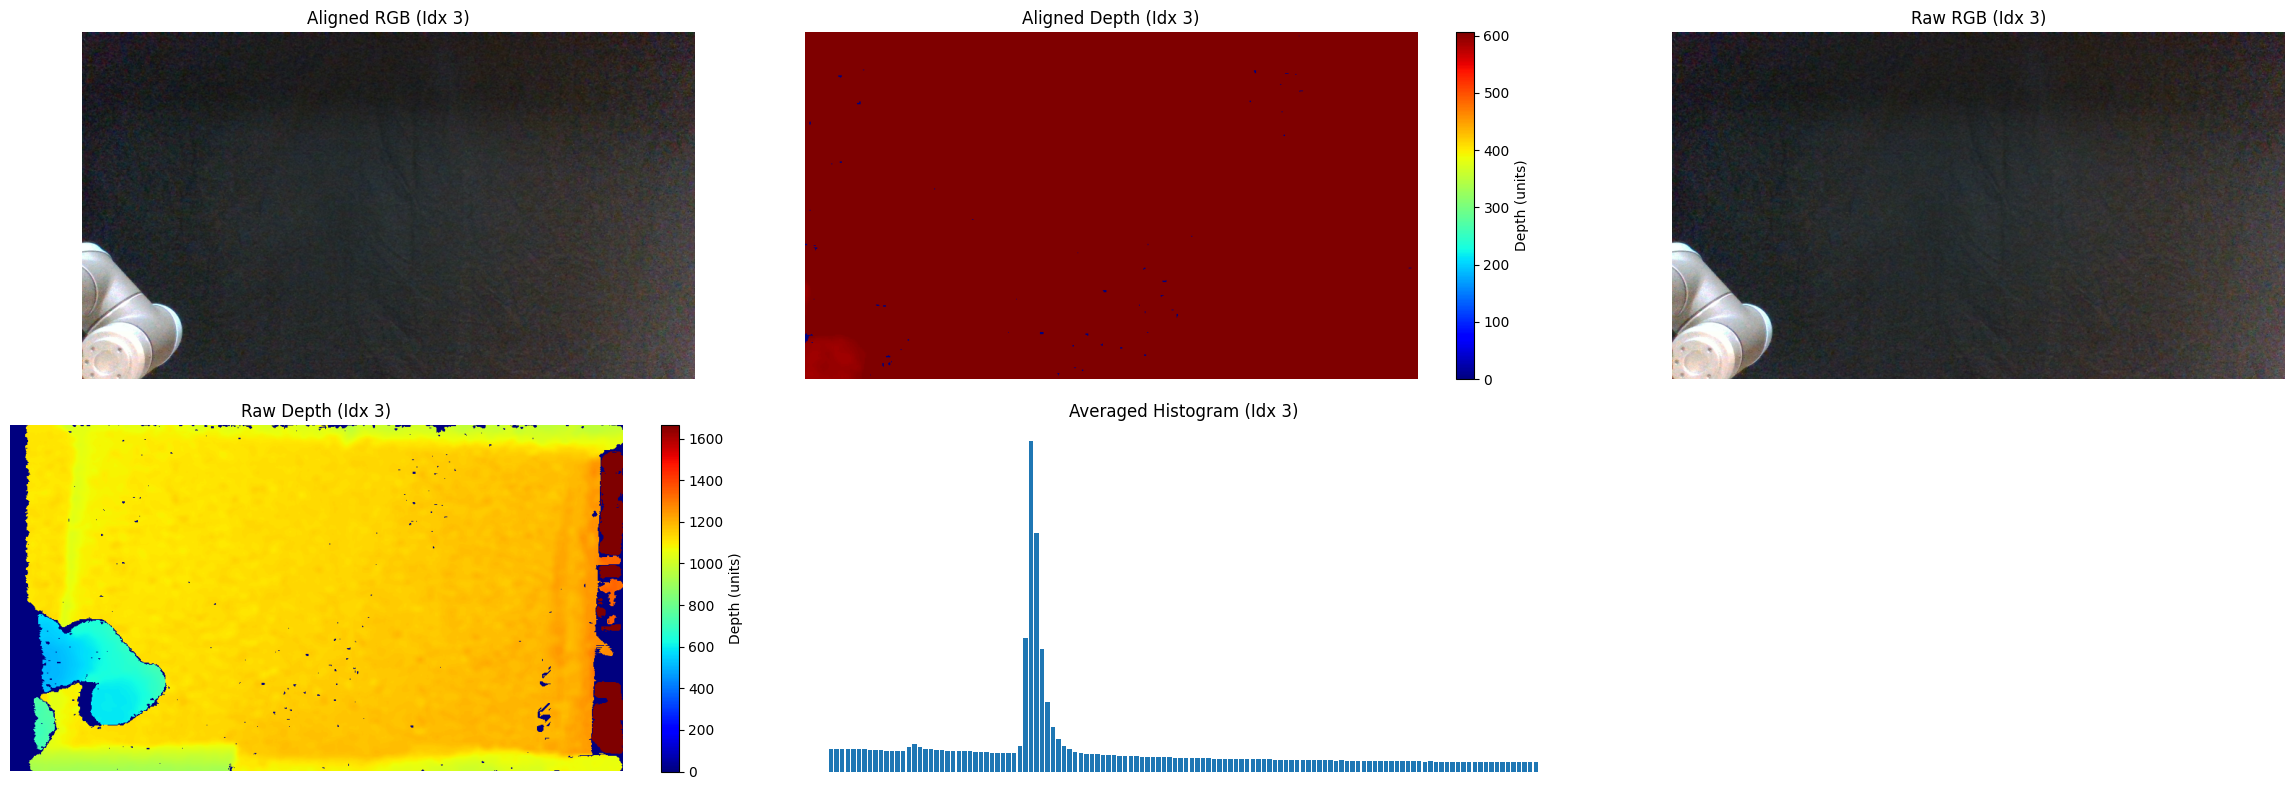

In [5]:
metadata_entry, data_entries = all_objs[0], all_objs[1:]

print("\n--- Metadata ---")
for k, v in metadata_entry.get("metadata", {}).items():
    if k == "realsense_intrinsics":
        print(f"  {k}:")
        for stream, intr in v.items():
            print(f"    {stream}:")
            for ik, iv in intr.items():
                print(f"      {ik}: {iv}")
    elif k == "robot_grid_points":
        try: print(f"  {k}: shape {v.shape}")
        except AttributeError: print(f"  {k}: length {len(v)}")
    else:
        print(f"  {k}: {v}")

num_captures = len(data_entries)
print(f"\nTotal captures available: {num_captures}")
if num_captures == 0:
    print("No actual capture data entries found.")
else:
    while True:
        try:
            capture_idx = int(input(f"Enter capture index (0 to {num_captures - 1}): ").strip())
            if 0 <= capture_idx < num_captures: break
            print(f"Invalid index. Please enter 0-{num_captures - 1}.")
        except ValueError:
            print("Invalid input. Please enter an integer.")

    cap = data_entries[capture_idx]
    print(f"\n--- Displaying Capture Index {capture_idx} ---\n  Iteration: {cap.get('iter')}\n  Position: {cap.get('pos')}")

    rs = cap.get("realsense_data", {})
    images = {
        "Aligned RGB": rs.get("aligned_rgb_image"),
        "Aligned Depth": rs.get("aligned_depth_image"),
        "Raw RGB": rs.get("raw_rgb_image"),
        "Raw Depth": rs.get("raw_depth_image")
    }
    histogram = cap.get(SPADDataType.HISTOGRAM)
    if histogram is None:
        histogram = cap.get("histogram")
    plt.figure(figsize=(24, 8))
    
    def print_res(name, img):
        if img is None: print(f"{name}: Not Found")
        else: print(f"{name}: {img.shape[1]}x{img.shape[0]}" + (f" (channels: {img.shape[2]})" if img.ndim==3 else " (grayscale/single-channel)"))
    for n, img in images.items(): print_res(n, img)

    for i, (title, img) in enumerate(list(images.items()) + [("Histogram", histogram)], 1):
        plt.subplot(2, 3, i)
        if title != "Histogram":
            if img is not None:
                plt.imshow(img[:, :, ::-1] if "RGB" in title else img, cmap='jet', vmin=0, vmax=np.max(img)*0.5 if "Depth" in title else None)
                plt.title(f"{title} (Idx {capture_idx})")
                if "Depth" in title: plt.colorbar(label='Depth (units)')
            else:
                plt.text(0.5, 0.5, f"{title} Not Found", ha='center', va='center', transform=plt.gca().transAxes)
        else:
            if img is not None:
                avg = img.mean(axis=(0,1)) if isinstance(img, np.ndarray) and img.ndim > 1 else img
                plt.bar(range(len(avg)), avg)
                plt.title(f"Averaged {title if 'SPAD' not in title else 'SPAD ' + title} (Idx {capture_idx})")
                plt.xlabel("Bin"); plt.ylabel("Count"); plt.grid(axis='y', alpha=0.75)
            else:
                plt.text(0.5, 0.5, "Histogram Not Found", ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
